In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
state = input("For which state do you want to see the Covid-19 Analysis? ")
print('\n')
print('Thank you for showing interest in ' + str(state)+ '. Scroll down to see the Covid-19 analysis of '+ str(state)+ '.')
split = .93

For which state do you want to see the Covid-19 Analysis? West Bengal


Thank you for showing interest in West Bengal. Scroll down to see the Covid-19 analysis of West Bengal.


In [ ]:
%%capture
import numpy as np
import pandas as pd
from statsmodels.tools.eval_measures import rmse
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from datetime import date
from datetime import datetime

!pip install lazypredict
!pip install catboost
!pip install lightgbm
from sklearn.utils import shuffle

from tqdm import tqdm
import time
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils.testing import all_estimators
from sklearn.base import RegressorMixin
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score, r2_score, mean_squared_error
import warnings
import xgboost
import catboost
import lightgbm

In [ ]:
#Raw data
data_tests = pd.read_csv("/content/drive/My Drive/Covid19 India/Tests_edited.csv")
data_cases = pd.read_csv("/content/drive/My Drive/Covid19 India/Cases_edited.csv")

In [ ]:
for i in range(len(data_cases)):
  data_cases.Date.iloc[i] = datetime.fromordinal(datetime(1900, 1, 1).toordinal() + data_cases.Date.iloc[i] - 2)
data_cases['Date'] = data_cases['Date'].dt.strftime('%m/%d/%Y')

for i in range(len(data_tests)):
  data_tests.Date.iloc[i] = datetime.fromordinal(datetime(1900, 1, 1).toordinal() + data_tests.Date.iloc[i] - 2)
data_tests['Date'] = data_tests['Date'].dt.strftime('%m/%d/%Y')

last_day = data_tests[-1:].iloc[0,0]
print('Complete data is updated till '+str(last_day)+'.')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Complete data is updated till 07/20/2020.


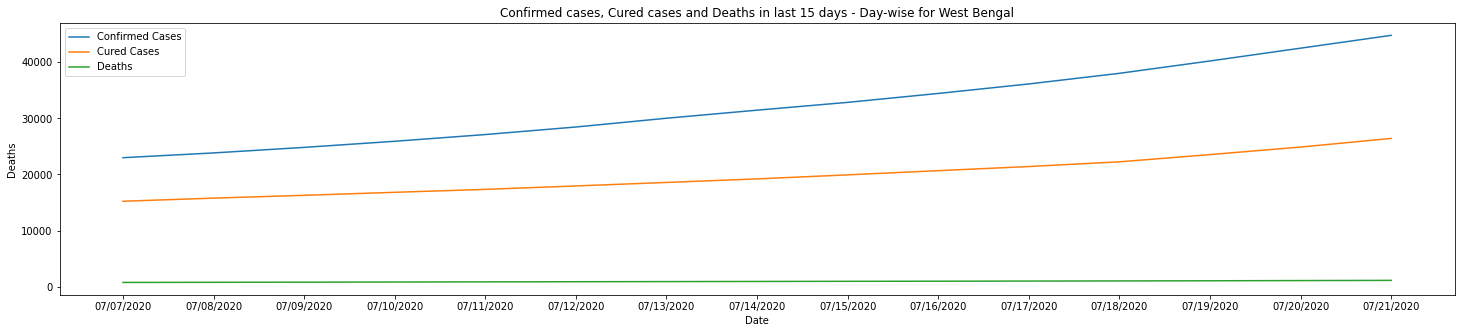

In [ ]:
plt.figure(figsize=(25,5))
sns.lineplot(x="Date", y="Confirmed", data=data_cases[data_cases['State/UnionTerritory'] == state ][-15:], Label = 'Confirmed Cases').set_title('Confirmed cases, Cured cases and Deaths in last 15 days - Day-wise for '+ str(state))
sns.lineplot(x="Date", y="Cured", data=data_cases[data_cases['State/UnionTerritory'] == state ][-15:], Label = 'Cured Cases').set_title('Confirmed cases, Cured cases and Deaths in last 15 days - Day-wise for '+ str(state))
sns.lineplot(x="Date", y="Deaths", data=data_cases[data_cases['State/UnionTerritory'] == state ][-15:], Label = 'Deaths').set_title('Confirmed cases, Cured cases and Deaths in last 15 days - Day-wise for '+ str(state))
plt.show()

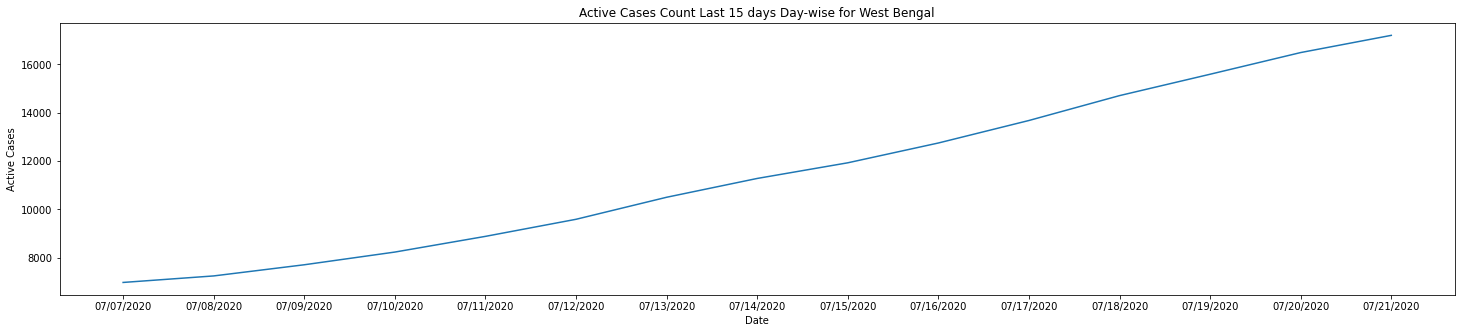



No. of Active Cases = No. of Confirmed Cases - No. of Recovered Cases - No. of Deaths


In [ ]:
#Active Cases Absolute Count
data_cases['Active Cases'] =  data_cases['Confirmed'] - data_cases['Cured'] - data_cases['Deaths']  
plt.figure(figsize=(25,5))
sns.lineplot(x="Date", y="Active Cases", data=data_cases[data_cases['State/UnionTerritory'] == state ][-15:]).set_title('Active Cases Count Last 15 days Day-wise for '+ str(state))
plt.show()

print('\n')
print('No. of Active Cases = No. of Confirmed Cases - No. of Recovered Cases - No. of Deaths')

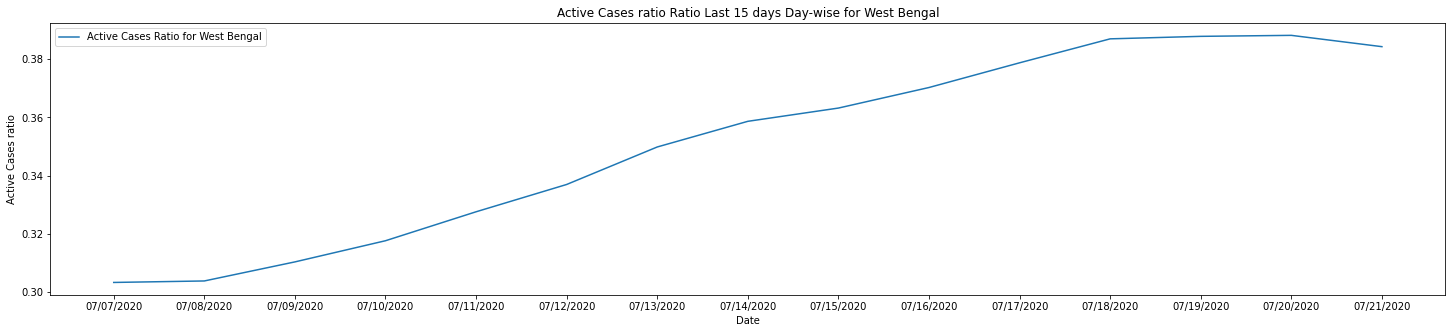



Active Cases ratio Ratio = No. of Active Cases/No. of Confirmed Cases


In [ ]:
#Active Cases ratio Count
data_cases['Active Cases ratio'] =  data_cases['Active Cases']/data_cases['Confirmed']
plt.figure(figsize=(25,5))
sns.lineplot(x="Date", y="Active Cases ratio", data=data_cases[data_cases['State/UnionTerritory'] == state][-15:], Label = 'Active Cases Ratio for '+ str(state)).set_title('Active Cases ratio Ratio Last 15 days Day-wise for '+ str(state))
plt.show()

print('\n')
print('Active Cases ratio Ratio = No. of Active Cases/No. of Confirmed Cases')

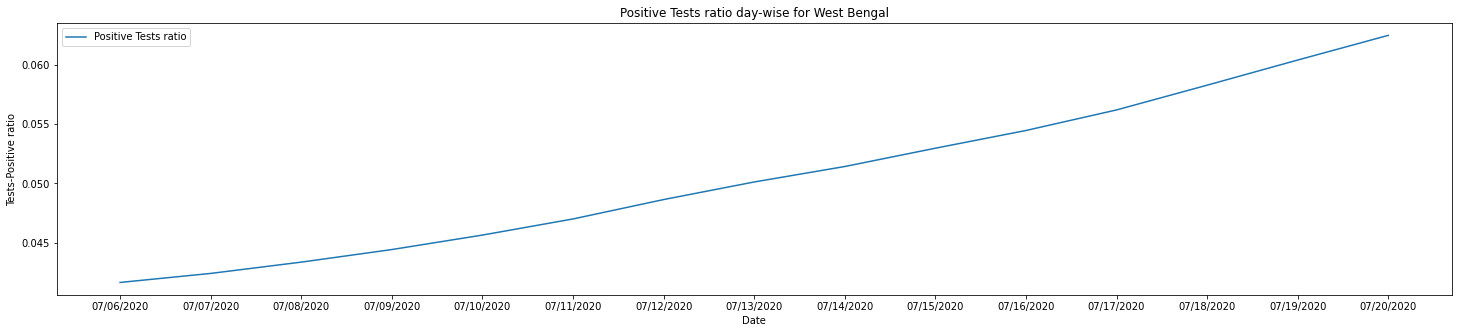



Positive Tests ratio = No. of people Tested as Covid-19 Positive/No. of Tests done


In [ ]:
#Tests-Positive ratio
data_tests['Tests-Positive ratio'] = data_tests['Positive']/data_tests['TotalSamples']
plt.figure(figsize=(25,5))
sns.lineplot(x="Date", y="Tests-Positive ratio", data=data_tests[data_tests['State'] == state ][-15:],Label = 'Positive Tests ratio').set_title('Positive Tests ratio day-wise for '+ str(state))
plt.show()

print('\n')
print('Positive Tests ratio = No. of people Tested as Covid-19 Positive/No. of Tests done')

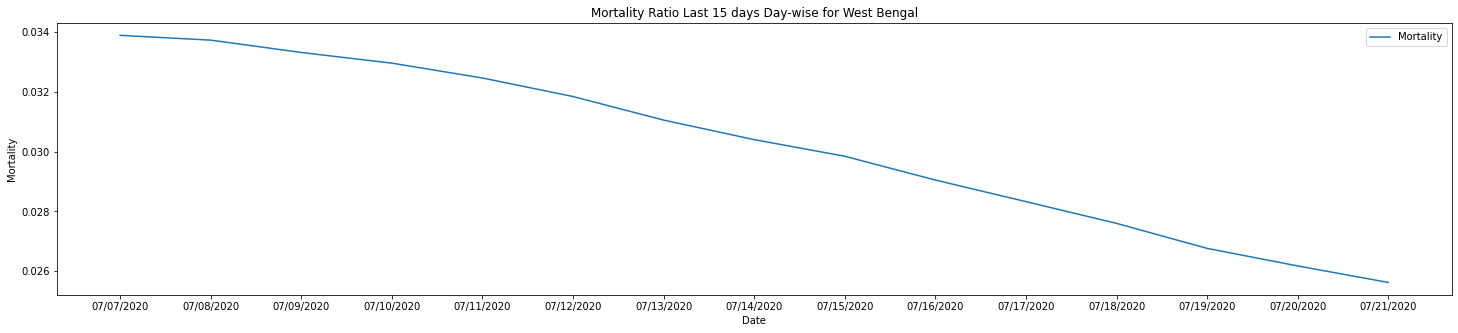



Mortality Ratio = No. of Deaths/No. of Confirmed Cases


In [ ]:
#Mortality Ratio
data_cases['Mortality'] =  data_cases['Deaths']/data_cases['Confirmed']
plt.figure(figsize=(25,5))
sns.lineplot(x="Date", y="Mortality", data=data_cases[data_cases['State/UnionTerritory'] == state][-15:], Label = 'Mortality').set_title('Mortality Ratio Last 15 days Day-wise for '+ str(state))
plt.show()


print('\n')
print('Mortality Ratio = No. of Deaths/No. of Confirmed Cases')

In [ ]:
#Raw data
data_tests = pd.read_csv("/content/drive/My Drive/Covid19 India/Tests_edited.csv")
data_cases = pd.read_csv("/content/drive/My Drive/Covid19 India/Cases_edited.csv")

In [ ]:
data_tests['Tests-Positive ratio'] = data_tests['Positive']/data_tests['TotalSamples']
data_cases['Active Cases'] =  data_cases['Confirmed'] - data_cases['Cured'] - data_cases['Deaths']
data_cases['Active Cases ratio'] =  data_cases['Active Cases']/data_cases['Confirmed']
data_cases['Mortality'] =  data_cases['Deaths']/data_cases['Confirmed']

In [ ]:
data_cases = data_cases[data_cases['State/UnionTerritory'] == state]
data_tests = data_tests[data_tests['State'] == state]
df = pd.merge(data_cases, data_tests, on='Date')
df = df.drop(['State'], axis=1)
df = df.dropna()
df = df.reset_index(drop=True)
for i in range(len(df)):
  df.Date.iloc[i] = datetime.fromordinal(datetime(1900, 1, 1).toordinal() + df.Date.iloc[i] - 2)
df['Date'] = df['Date'].dt.strftime('%m/%d/%Y')
df_cal = df

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [ ]:
df_cal['Target'] = df_cal['Active Cases']
df_cal['Target'][0:-1] = df_cal['Active Cases'][1:]
df = df_cal[:-1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
X, y = df.iloc[:,2:11], df.Target
X = X.astype(np.float32)
offset = int(X.shape[0] * split)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]
data_tom = df_cal[-1:].iloc[:,2:11]

In [ ]:
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 2)
pd.set_option("display.float_format", lambda x: '%.2f' % x)

In [ ]:
REGRESSORS = [est for est in all_estimators() if issubclass(est[1], RegressorMixin)]

removed_regressors = [('TheilSenRegressor', sklearn.linear_model.theil_sen.TheilSenRegressor),
 ('ARDRegression', sklearn.linear_model.ARDRegression),
 ('CCA', sklearn.cross_decomposition.CCA),
 ('IsotonicRegression', sklearn.isotonic.IsotonicRegression),
 ('MultiOutputRegressor', sklearn.multioutput.MultiOutputRegressor),
 ('MultiTaskElasticNet',
  sklearn.linear_model.MultiTaskElasticNet),
 ('MultiTaskElasticNetCV',
  sklearn.linear_model.MultiTaskElasticNetCV),
 ('MultiTaskLasso', sklearn.linear_model.MultiTaskLasso),
 ('MultiTaskLassoCV',
  sklearn.linear_model.MultiTaskLassoCV),
 ('PLSCanonical', sklearn.cross_decomposition.PLSCanonical),
 ('PLSRegression', sklearn.cross_decomposition.PLSRegression),
 ('RadiusNeighborsRegressor',
  sklearn.neighbors.RadiusNeighborsRegressor),
 ('RegressorChain', sklearn.multioutput.RegressorChain),
 ('VotingRegressor', sklearn.ensemble.VotingRegressor),
 ('_SigmoidCalibration', sklearn.calibration._SigmoidCalibration)]

for i in removed_regressors:
    REGRESSORS.pop(REGRESSORS.index(i))
    
REGRESSORS.append(('XGBRegressor', xgboost.XGBRegressor))
REGRESSORS.append(('LGBMRegressor',lightgbm.LGBMRegressor))
REGRESSORS.append(('CatBoostRegressor',catboost.CatBoostRegressor))

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer_low = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoding', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

categorical_transformer_high = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    # 'OrdianlEncoder' Raise a ValueError when encounters an unknown value. Check https://github.com/scikit-learn/scikit-learn/pull/13423
    ('encoding', OrdinalEncoder())
])


# Helper function

def get_card_split(df, cols, n=11):
    cond = df[cols].nunique() > n
    card_high = cols[cond]
    card_low  = cols[~cond]
    return card_low, card_high


In [ ]:
class AgnosticRegressor:
  def __init__(self, verbose=0, ignore_warnings=True, custom_metric = None, predictions = False,random_state=42):
        self.verbose = verbose
        self.ignore_warnings = ignore_warnings
        self.custom_metric = custom_metric
        self.predictions = predictions
        self.random_state = random_state

  def fit(self, X_train, X_test, y_train, y_test):
      R2 = []
      RMSE = []
      names = []
      TIME = []
      predictions = {}
        
      if self.custom_metric != None:
          CUSTOM_METRIC = []

      if type(X_train) is np.ndarray:
          X_train = pd.DataFrame(X_train)
          X_test = pd.DataFrame(X_test)

      numeric_features = X_train.select_dtypes(
          include=['int64', 'float64', 'int32', 'float32']).columns
      categorical_features = X_train.select_dtypes(
          include=['object']).columns
        
      categorical_low, categorical_high = get_card_split(X_train, categorical_features)

      preprocessor = ColumnTransformer(
          transformers=[
              ('numeric', numeric_transformer, numeric_features),
              ('categorical_low', categorical_transformer_low, categorical_low),
              ('categorical_high', categorical_transformer_high, categorical_high)
          ])

      for name, model in tqdm(REGRESSORS):
          start = time.time()
          try:
              if 'random_state' in model().get_params().keys():
                  pipe = Pipeline(steps=[
                      ('preprocessor', preprocessor),
                      ('regressor', model(random_state = self.random_state))
                  ])
              else:
                  pipe = Pipeline(steps=[
                  ('preprocessor', preprocessor),
                  ('regressor', model())
              ])
              pipe.fit(X_train, y_train)
              y_pred = pipe.predict(X_test)
              r_squared = r2_score(y_test, y_pred)
              rmse = np.sqrt(mean_squared_error(y_test, y_pred))
              names.append(name)
              R2.append(r_squared)
              RMSE.append(rmse)
              TIME.append(time.time() - start)
              if self.custom_metric != None:
                  custom_metric = self.custom_metric(y_test, y_pred)
                  CUSTOM_METRIC.append(custom_metric)

              if self.verbose > 0:
                  if self.custom_metric != None:
                      print({"Model": name,
                              "R-Squared": r_squared,
                              "RMSE": rmse,
                              self.custom_metric.__name__: custom_metric,
                            "Time taken": time.time() - start})
                  else:
                      print({"Model": name,
                              "R-Squared": r_squared,
                              "RMSE": rmse,
                            "Time taken": time.time() - start})
              if self.predictions == True:
                  predictions[name]=y_pred
          except Exception as exception:
              if self.ignore_warnings == False:
                  print(name + " model failed to execute")
                  print(exception)
                    
      if self.custom_metric == None:
          scores = pd.DataFrame({"Model": names, 
                                  "R-Squared": R2, 
                                  "RMSE": RMSE,
                                  "Time Taken": TIME})
      else:
          scores = pd.DataFrame({"Model": names, 
                                  "R-Squared": R2, 
                                  "RMSE": RMSE,
                                self.custom_metric.__name__: CUSTOM_METRIC,
                                "Time Taken": TIME})
      scores = scores.sort_values(
          by='R-Squared', ascending=False).set_index('Model')

      return scores  



  def pred(self, X,y,data_tom):
    names = []
    tom = []
    
    if type(X) is np.ndarray:
      X = pd.DataFrame(X)
    
    numeric_features = X.select_dtypes(
        include=['int64', 'float64', 'int32', 'float32']).columns
    categorical_features = X.select_dtypes(
        include=['object']).columns
        
    categorical_low, categorical_high = get_card_split(X, categorical_features)

    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', numeric_transformer, numeric_features),
            ('categorical_low', categorical_transformer_low, categorical_low),
            ('categorical_high', categorical_transformer_high, categorical_high)
                    ])

    for name, model in tqdm(REGRESSORS):
      try:
        start = time.time()
        if 'random_state' in model().get_params().keys():
          pipe = Pipeline(steps=[('preprocessor', preprocessor),('regressor', model(random_state = self.random_state))])
        else:
          pipe = Pipeline(steps=[('preprocessor', preprocessor),('regressor', model())])
      
        pipe.fit(X, y)
        y_tom = pipe.predict(data_tom)
        names.append(name)
        tom.append(int(y_tom))
      
      except Exception as exception:
        if self.ignore_warnings == False:
          print(name + " model failed to execute")
          print(exception)
              
    result = pd.DataFrame({"Model": names, 
                           "Tomorrow's Prediction":tom, 
                           })
    result = result.set_index('Model')
    return result 

In [ ]:
%%capture
ma_model = AgnosticRegressor()
score = ma_model.fit(X_train, X_test, y_train, y_test)
pred = ma_model.pred(X,y,data_tom)
result = pd.merge(score, pred, left_index=True, right_index=True)

In [ ]:
Forecast = result["Tomorrow's Prediction"][0]
Model = result.index[0]
n = int(data_tom['Active Cases'])
increase_abs = Forecast - n
increase_rate = (Forecast - n)/n
decrease_abs = (increase_abs*-1)
decrease_rate = (increase_rate*-1)

import datetime
yesterday = df[-1:].iloc[0,0]
yesterday = pd.to_datetime(yesterday)
today = yesterday + datetime.timedelta(days=1)
tomorrow = yesterday + datetime.timedelta(days=2)

In [ ]:
finmod = [mod for mod in REGRESSORS 
          if mod[0] == result.index[0] or mod[1] == result.index[0]]

In [ ]:
class FinalRegressor:
  def __init__(self, verbose=0, ignore_warnings=True, custom_metric = None, predictions = False,random_state=42):
        self.verbose = verbose
        self.ignore_warnings = ignore_warnings
        self.custom_metric = custom_metric
        self.predictions = predictions
        self.random_state = random_state

  def predplot(self, X_train, X_test, y_train, y_test):
    names = []
    if type(X_train) is np.ndarray:
      X_train = pd.DataFrame(X_train)
      X_test = pd.DataFrame(X_test)

    numeric_features = X_train.select_dtypes(
        include=['int64', 'float64', 'int32', 'float32']).columns
    categorical_features = X_train.select_dtypes(
        include=['object']).columns
        
    categorical_low, categorical_high = get_card_split(X_train, categorical_features)

    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', numeric_transformer, numeric_features),
            ('categorical_low', categorical_transformer_low, categorical_low),
            ('categorical_high', categorical_transformer_high, categorical_high)
        ])

    for name, model in tqdm(finmod):
      try:
        if 'random_state' in model().get_params().keys():
          pipe = Pipeline(steps=[('preprocessor', preprocessor),('regressor', model(random_state = self.random_state))])
        else:
          pipe = Pipeline(steps=[('preprocessor', preprocessor),('regressor', model())])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        
        y_pred = pd.DataFrame(y_pred)
        y_pred.columns = ['Active Cases']
        y_pred.index = pd.date_range(end = today, periods=y_pred.shape[0], freq='D',)
        
        y_test = pd.DataFrame(y_test)
        y_test.columns = ['Active Cases']
        y_test.index = pd.date_range(end = today, periods=y_test.shape[0], freq='D',)

      except Exception as exception:
        if self.ignore_warnings == False:
          print(name + " model failed to execute")
          print(exception)

      plt.figure(figsize=(10,5))
      sns.lineplot(x=y_pred.index, y=y_pred['Active Cases'], data=y_pred, label = 'Forecast').set_title(str(result.index[0])+ ' : Actual Cases vs Forecast Cases count for Last ' +str(int(y_test.shape[0]))+ ' days Day-wise for '+ str(state))
      sns.lineplot(x=y_test.index, y=y_test['Active Cases'], data=y_test, label = 'Actual').set_title(str(result.index[0])+ ' : Actual Cases vs Forecast Cases count for Last ' +str(int(y_test.shape[0]))+ ' days Day-wise for '+ str(state))
      plt.show()

In [ ]:
best_rsq = result.iloc[0][0]
print('Best R-Squared: ' +str(best_rsq))
best_rmse = result.iloc[0][1]
print('Best RMSE: ' +str(best_rmse))

Best R-Squared: 0.9969870072265038
Best RMSE: 97.91569373029088


  0%|          | 0/1 [00:00<?, ?it/s]

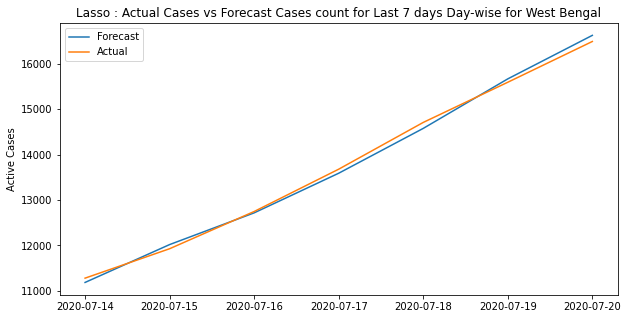

100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


In [ ]:
fin_reg = FinalRegressor()
plot = fin_reg.predplot(X_train, X_test, y_train, y_test)

In [ ]:
print('As per the forecasting performed by ' +str(Model)+ ' model, ')
if (n < Forecast):
  print('the active COVID-19 cases count of ' +str(state)+ ' is estimated to increase by ')
  print("{0:.2%}".format(increase_rate)+ ' (absolute count = ' +str(increase_abs)+ ') tomorrow (' + str(tomorrow)+ ') , taking the state total to ' +str(Forecast)+ '.')
elif (n == Forecast):
  print('the active COVID-19 cases count of ' +str(state)+ ' will not increase tomorrow (' + str(tomorrow)+ ').')
  print('The state total will remain constant at ' +str(Forecast)+ '.')
else:
  print('the active COVID-19 cases count of ' +str(state)+ ' is estimated to decrease by ')
  print("{0:.2%}".format(decrease_rate)+ ' (absolute count = ' +str(decrease_abs)+ ') tomorrow (' + str(tomorrow)+ ') , taking the state total of active cases to ' +str(Forecast)+ '.')
print('\n')  
print('Disclaimer: The estimated aboslute figures can deviate within 5%.')
print('* Thank You for visiting, hope you found the information useful *')


As per the forecasting performed by Lasso model, 
the active COVID-19 cases count of West Bengal is estimated to increase by 
6.60% (absolute count = 1088) tomorrow (2020-07-21 00:00:00) , taking the state total to 17580.


Disclaimer: The estimated aboslute figures can deviate within 5%.
* Thank You for visiting, hope you found the information useful *


In [ ]:
input_days = input("For how many days do you want to see the Covid-19 forecast for " +str(state)+ " ? ")
days = int(input_days)+1
time_taken = int(int(days/5)*2.9)

print('\n')
if int(input_days) ==1:
  print('Thank you. Please give us few minutes to calculate Covid-19 forecast of ' +str(input_days)+ ' day for ' + str(state)+ '.')
else:
  print('Thank you. Please give us few minutes to calculate Covid-19 forecast of ' +str(input_days)+ ' days for ' + str(state)+ '.')

if int(time_taken) <=1:
  print('Approximate time for calculation is ' +str(time_taken)+ ' minute, please scroll down.')
else:
  print('Approximate time for calculation is ' +str(time_taken)+ ' minutes, please scroll down.')

For how many days do you want to see the Covid-19 forecast for West Bengal ? 135


Thank you. Please give us few minutes to calculate Covid-19 forecast of 135 days for West Bengal.
Approximate time for calculation is 60 minutes, please scroll down.


In [ ]:
#Raw data
data_tests = pd.read_csv("/content/drive/My Drive/Covid19 India/Tests_edited.csv")
data_cases = pd.read_csv("/content/drive/My Drive/Covid19 India/Cases_edited.csv")

In [ ]:
data_tests['Tests-Positive ratio'] = data_tests['Positive']/data_tests['TotalSamples']
data_cases['Active Cases'] =  data_cases['Confirmed'] - data_cases['Cured'] - data_cases['Deaths']
data_cases['Active Cases ratio'] =  data_cases['Active Cases']/data_cases['Confirmed']
data_cases['Mortality'] =  data_cases['Deaths']/data_cases['Confirmed']

In [ ]:
data_cases = data_cases[data_cases['State/UnionTerritory'] == state]
data_tests = data_tests[data_tests['State'] == state]
df = pd.merge(data_cases, data_tests, on='Date')
df = df.drop(['State'], axis=1)
df = df.dropna()
df = df.reset_index(drop=True)

from datetime import date
from datetime import datetime
for i in range(len(df)):
  df.Date.iloc[i] = datetime.fromordinal(datetime(1900, 1, 1).toordinal() + df.Date.iloc[i] - 2)
df['Date'] = df['Date'].dt.strftime('%m/%d/%Y')
df_cal = df
df_cal.Positive = (df_cal.Positive).astype(int)
org_len = len(df_cal)

In [ ]:
df_duration = df_cal[['Date', 'State/UnionTerritory', 'Cured', 'Deaths', 'Confirmed', 'TotalSamples', 'Positive']]

#Calculate difference from inception
df_duration['Date']= pd.to_datetime(df_duration['Date'])
x = df_duration.Date.min()
for i in range(len(df_duration)):
  df_duration['Date'][i] = (df_duration['Date'][i] - x).days
df_duration = df_duration[['State/UnionTerritory', 'Date',  'TotalSamples', 'Confirmed', 'Cured', 'Deaths', 'Positive']]
df_duration.rename(columns={'Date': 'Duration'}, inplace=True)

In [ ]:
%%capture
df_cal = df_duration.iloc[:,1:]
col_list = df_cal.columns[1:]

my_dict = {}
model_dict = {}
for i in range(days):
  for column in col_list:
    print(column)
    df_cal['Target'] = df_cal[column]
    df_cal['Target'][0:-1] = df_cal[column][1:]
    df = df_cal[:-1]
        
    X, y = df.iloc[:,0:6], df.Target
    X = X.astype(np.float32)
    offset = int(X.shape[0] * split)
    X_train, y_train = X[:offset], y[:offset]
    X_test, y_test = X[offset:], y[offset:]
    data_tom = df_cal[-1:].iloc[:,0:6]

    ma_model = AgnosticRegressor()
    score = ma_model.fit(X_train, X_test, y_train, y_test) 
    pred = ma_model.pred(X,y,data_tom);
    result = pd.merge(score, pred, left_index=True, right_index=True)

    outcome = result["Tomorrow's Prediction"][0]
    my_dict['Duration'] = [int(int(data_tom.iloc[0,0])+1)]
    my_dict[column] = [outcome]

    if i in model_dict.keys():
      model_dict[i].append(result.index[0])
    else:
      model_dict[i] = [result.index[0]]
      
  df_step = pd.DataFrame(my_dict)
  df_cal = df_cal.append(df_step)

ValueError: ignored

In [ ]:
df_forecast = df_cal.iloc[org_len:,1:5]

place = []
for i in range(len(df_forecast)):
  place.append(state)
df_forecast.insert(0, "State/UnionTerritory", place, True)

df_forecast.index = pd.date_range(start = tomorrow, periods=df_forecast.shape[0], freq='D',)
Date = []
for day in df_forecast.index:
  Date.append(day)
df_forecast.insert(0, "Date", Date, True)
df_forecast = df_forecast.reset_index(drop=True)

active_cases = []
for i in range(len(df_forecast)):
  active_cases.append(df_forecast.Confirmed[i] - df_forecast.Cured[i] - df_forecast.Deaths[i])
df_forecast.insert(6, "Active Cases", active_cases, True)

norm_active_cases = []
for i in range(len(df_forecast)):
  norm_active_cases.append(df_forecast['Active Cases'][i]/df_forecast.Confirmed[i])
df_forecast.insert(7, "Active Cases ratio", norm_active_cases, True)

mortality = []
for i in range(len(df_forecast)):
  mortality.append(df_forecast['Deaths'][i]/df_forecast.Confirmed[i])
df_forecast.insert(8, "Mortality", mortality, True)

tp_ratio = []
for i in range(len(df_forecast)):
  if (i+1) == len(df_forecast):
    tp_ratio.append(df_forecast['Confirmed'][i]/df_forecast.TotalSamples[i])
  else:
    tp_ratio.append(df_forecast['Confirmed'][i+1]/df_forecast.TotalSamples[i])
df_forecast.insert(9, "Tests-Positive ratio", tp_ratio, True)
df_forecast = df_forecast[:-1]

In [ ]:
pred_models = pd.DataFrame(model_dict).T
pred_models.columns = ['TotalSamples_Model','Confirmed_Model','Cured_Model','Deaths_Model','Positive_Model']
pred_models.reset_index(drop=True)
df_forecast.reset_index(drop=True)
df_full = pd.concat([df_forecast,pred_models], axis = 1)
df_full = df_full.iloc[:-1,0:-1]

In [ ]:
if int(input_days) ==1:
  file_name = 'Forecast_'+str(state)+'_'+str(input_days)+'day.csv'
else:
  file_name = 'Forecast_'+str(state)+'_'+str(input_days)+'days.csv'
df_forecast.to_csv("/content/drive/My Drive/Covid19 India/"+str(file_name))

In [ ]:
print('The following forecast would be valid, provided the below conditions:') 
print('1. ' + str(state)+ ' continues to increase Covid-19 sample tests in the same rate as it is doing now for the next ' +str(input_days)+ ' days.')
print('2. ' + str(state)+ ' Govt. does not deploy any new strategic measure to control the infection surge for the next ' +str(input_days)+ ' days.')
print('\n')
if int(input_days) ==1:
  print('Showing Covid-19 forecast of ' +str(input_days)+ ' day for ' + str(state)+ ' :-')
else:
  print('Showing Covid-19 forecast of ' +str(input_days)+ ' days for ' + str(state)+ ' :-')
print('\n')
print(df_forecast.to_string(index=False))

The following forecast would be valid, provided the below conditions:
1. West Bengal continues to increase Covid-19 sample tests in the same rate as it is doing now for the next 135 days.
2. West Bengal Govt. does not deploy any new strategic measure to control the infection surge for the next 135 days.


Showing Covid-19 forecast of 135 days for West Bengal :-


      Date State/UnionTerritory  TotalSamples  Confirmed    Cured  Deaths  Active Cases  Active Cases ratio  Mortality  Tests-Positive ratio
2020-07-21          West Bengal        726636      44779    26033    1142         17604                0.39       0.03                  0.07
2020-07-22          West Bengal        737181      47261    27254    1173         18834                0.40       0.02                  0.07
2020-07-23          West Bengal        744981      49942    28648    1206         20088                0.40       0.02                  0.07
2020-07-24          West Bengal        755595      52840    30133    1